<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/tempMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install cfgrib
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 95.3 MB/s eta 0:00:00


In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from datetime import datetime as dt
import cfgrib

#User parameters

In [64]:
name = "Milton"
tcNum = "14"
trackType = ""

initTime = dt(year=2024, month=10, day=7, hour=0) #Time when Milton began its most rapid intensification

fHourStep = 12      #Normally 3 for HAFS-A
forecastLength = 54 #Normally 126 for HAFS-A.
#runStep = 6         #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

#Retrieve HAFS-A Data

Find times needed

In [65]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

#Times to plot
fcastTimes = [] #Key: initiation, item: valid time list
fhour = 0
validTime = initTime
while fhour <= forecastLength:
    fcastTimes.append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

#All forecast times
allTimes = [] #Key: initiation, item: valid time list
fhour = 0
validTime = initTime
while fhour <= forecastLength:
    allTimes.append(validTime)
    validTime += pd.Timedelta(hours=3)
    fhour += 3

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [66]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

initStr, initHour = initTime.strftime("%Y%m%d_%H").split("_")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

--2025-07-23 23:08:54--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/00/14l.2024100700.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 3.5.24.211, 3.5.24.104, 16.182.69.137, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|3.5.24.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35636 (35K) [application/octet-stream]
Saving to: ‘atcf_20241007_00.csv’

atcf_20241007_00.cs 100%[===================>]  34.80K  --.-KB/s    in 0.06s   

2025-07-23 23:08:55 (550 KB/s) - ‘atcf_20241007_00.csv’ saved [35636/35636]



In [67]:
tcLocs = {}

for valid in allTimes:
    fHour = int((valid-initTime).total_seconds() / 3600)

    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[valid] = (pointLat, pointLon)

In [68]:
tcLocs

{datetime.datetime(2024, 10, 7, 0, 0): (22.4, -93.4),
 datetime.datetime(2024, 10, 7, 3, 0): (22.3, -93.2),
 datetime.datetime(2024, 10, 7, 6, 0): (22.2, -92.8),
 datetime.datetime(2024, 10, 7, 9, 0): (22.1, -92.4),
 datetime.datetime(2024, 10, 7, 12, 0): (22.0, -92.0),
 datetime.datetime(2024, 10, 7, 15, 0): (22.0, -91.5),
 datetime.datetime(2024, 10, 7, 18, 0): (22.1, -91.0),
 datetime.datetime(2024, 10, 7, 21, 0): (22.2, -90.6),
 datetime.datetime(2024, 10, 8, 0, 0): (22.3, -90.1),
 datetime.datetime(2024, 10, 8, 3, 0): (22.4, -89.6),
 datetime.datetime(2024, 10, 8, 6, 0): (22.5, -89.2),
 datetime.datetime(2024, 10, 8, 9, 0): (22.8, -88.7),
 datetime.datetime(2024, 10, 8, 12, 0): (22.9, -88.4),
 datetime.datetime(2024, 10, 8, 15, 0): (23.1, -87.9),
 datetime.datetime(2024, 10, 8, 18, 0): (23.3, -87.6),
 datetime.datetime(2024, 10, 8, 21, 0): (23.6, -87.1),
 datetime.datetime(2024, 10, 9, 0, 0): (23.9, -86.6),
 datetime.datetime(2024, 10, 9, 3, 0): (24.3, -86.2),
 datetime.datetime(2

#Figures

Set Figure Parameters

In [69]:
lonMin, lonMax, latMin, latMax = -95, -85, 21, 26

atmLayers = [0, 2, 4, 6, 8, 10]
oceLayers = [0, 2, 4, 6, 8, 10]

buffer = 0.1 / len(atmLayers)
xWidth = 0.8 / len(fcastTimes)
yWidth = 0.4 / len(atmLayers)
xcorners = np.arange(0.1,0.9,xWidth)
ycorners = np.arange(0.7,0.3,-yWidth)

diffType = "top" #top or incremental

Atmospheric Temperature

/tmp/ipython-input-70-126959932.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-70-126959932.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue dec

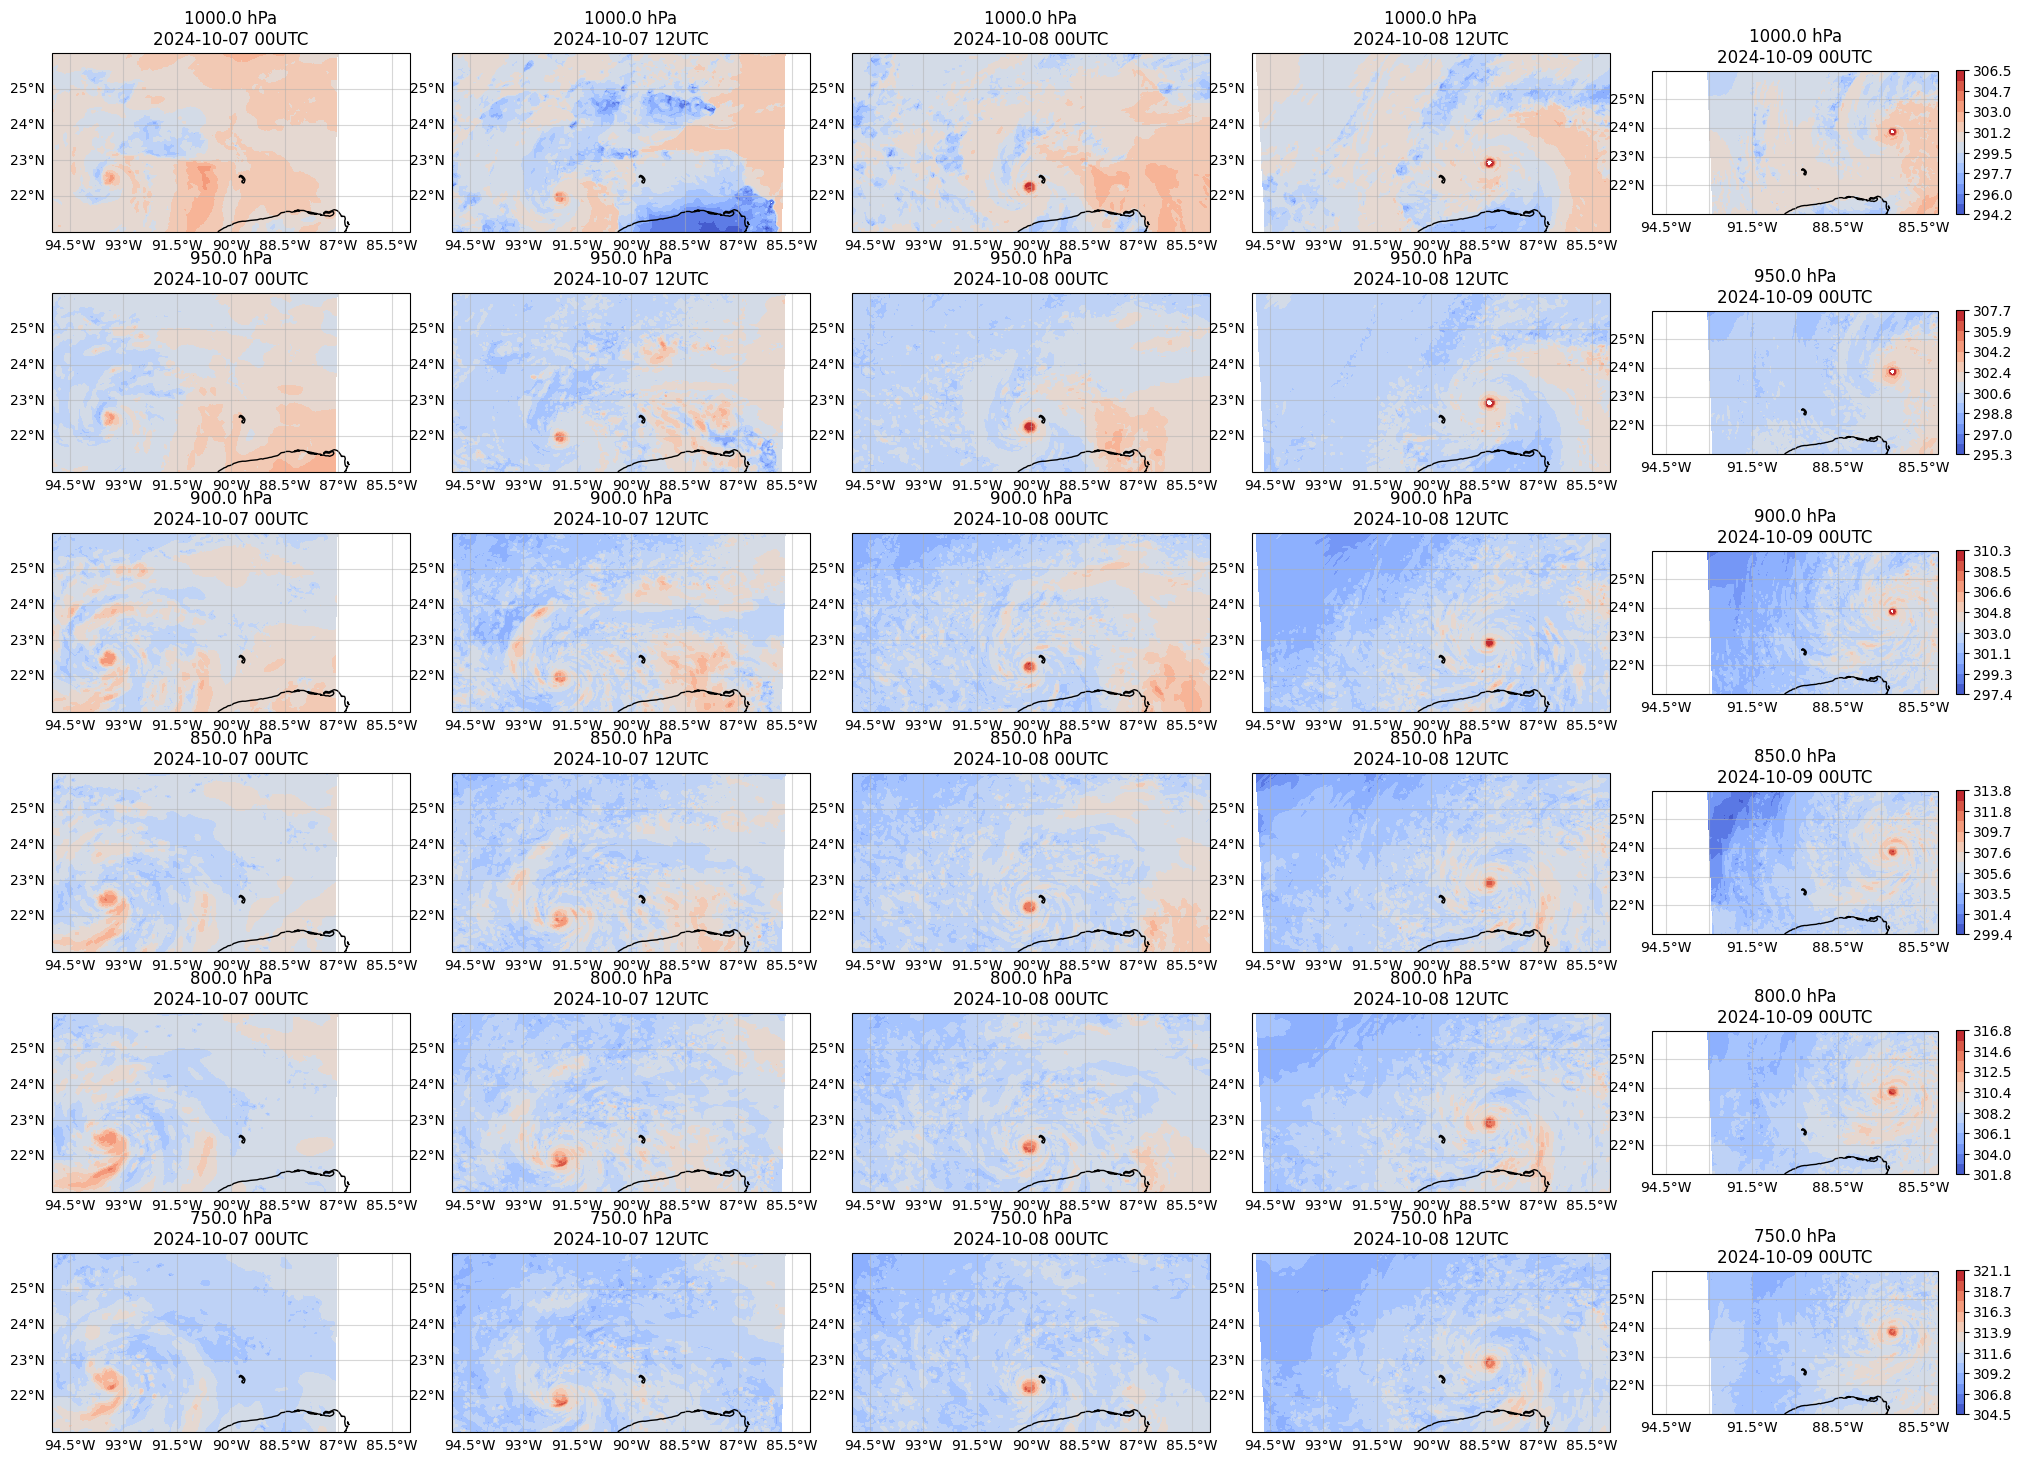

In [70]:
atmFig = plt.figure(figsize=(len(fcastTimes)*5,len(atmLayers)*6))
atmAxes = [[atmFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

contourLevs = {layer:["Empty"] for layer in atmLayers}
for valid, atmAxColumn in zip(fcastTimes, atmAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + initHour + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  for atmLayer, atmAx in zip(atmLayers, atmAxColumn):

    atmSlice = atmData.isel(isobaricInhPa=atmLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))

    if potentialTemp: temp = atmSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286
    else: temp = atmSlice.t.data

    if "Empty" in contourLevs[atmLayer]: contourLevs[atmLayer] = [round(l, 1) for l in np.linspace(np.min(temp[np.isnan(temp)==False])-3, np.max(temp[np.isnan(temp)==False])+3, 15)]

    tempContour = atmAx.contourf(atmSlice.longitude.data, atmSlice.latitude.data, temp, cmap="coolwarm", transform=ccrs.PlateCarree(),
                                extent = [lonMin, lonMax, latMin, latMax], levels=contourLevs[atmLayer])

    if valid == fcastTimes[-1]: atmFig.colorbar(tempContour, shrink=0.8)

    #atmAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=75, transform=ccrs.PlateCarree())

    atmAx.add_feature(cft.COASTLINE)
    atmAx.add_feature(cft.BORDERS)
    atmAx.gridlines(draw_labels=["left", "bottom"], alpha=0.5)
    atmAx.set_title(f'{atmData.isobaricInhPa.data[atmLayer]} hPa\n{valid.strftime("%Y-%m-%d %HUTC")}')

    atmAx.set_extent([lonMin, lonMax, latMin, latMax])

#atmFig.suptitle(f"Atmosphere Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

Oceanic Temperature

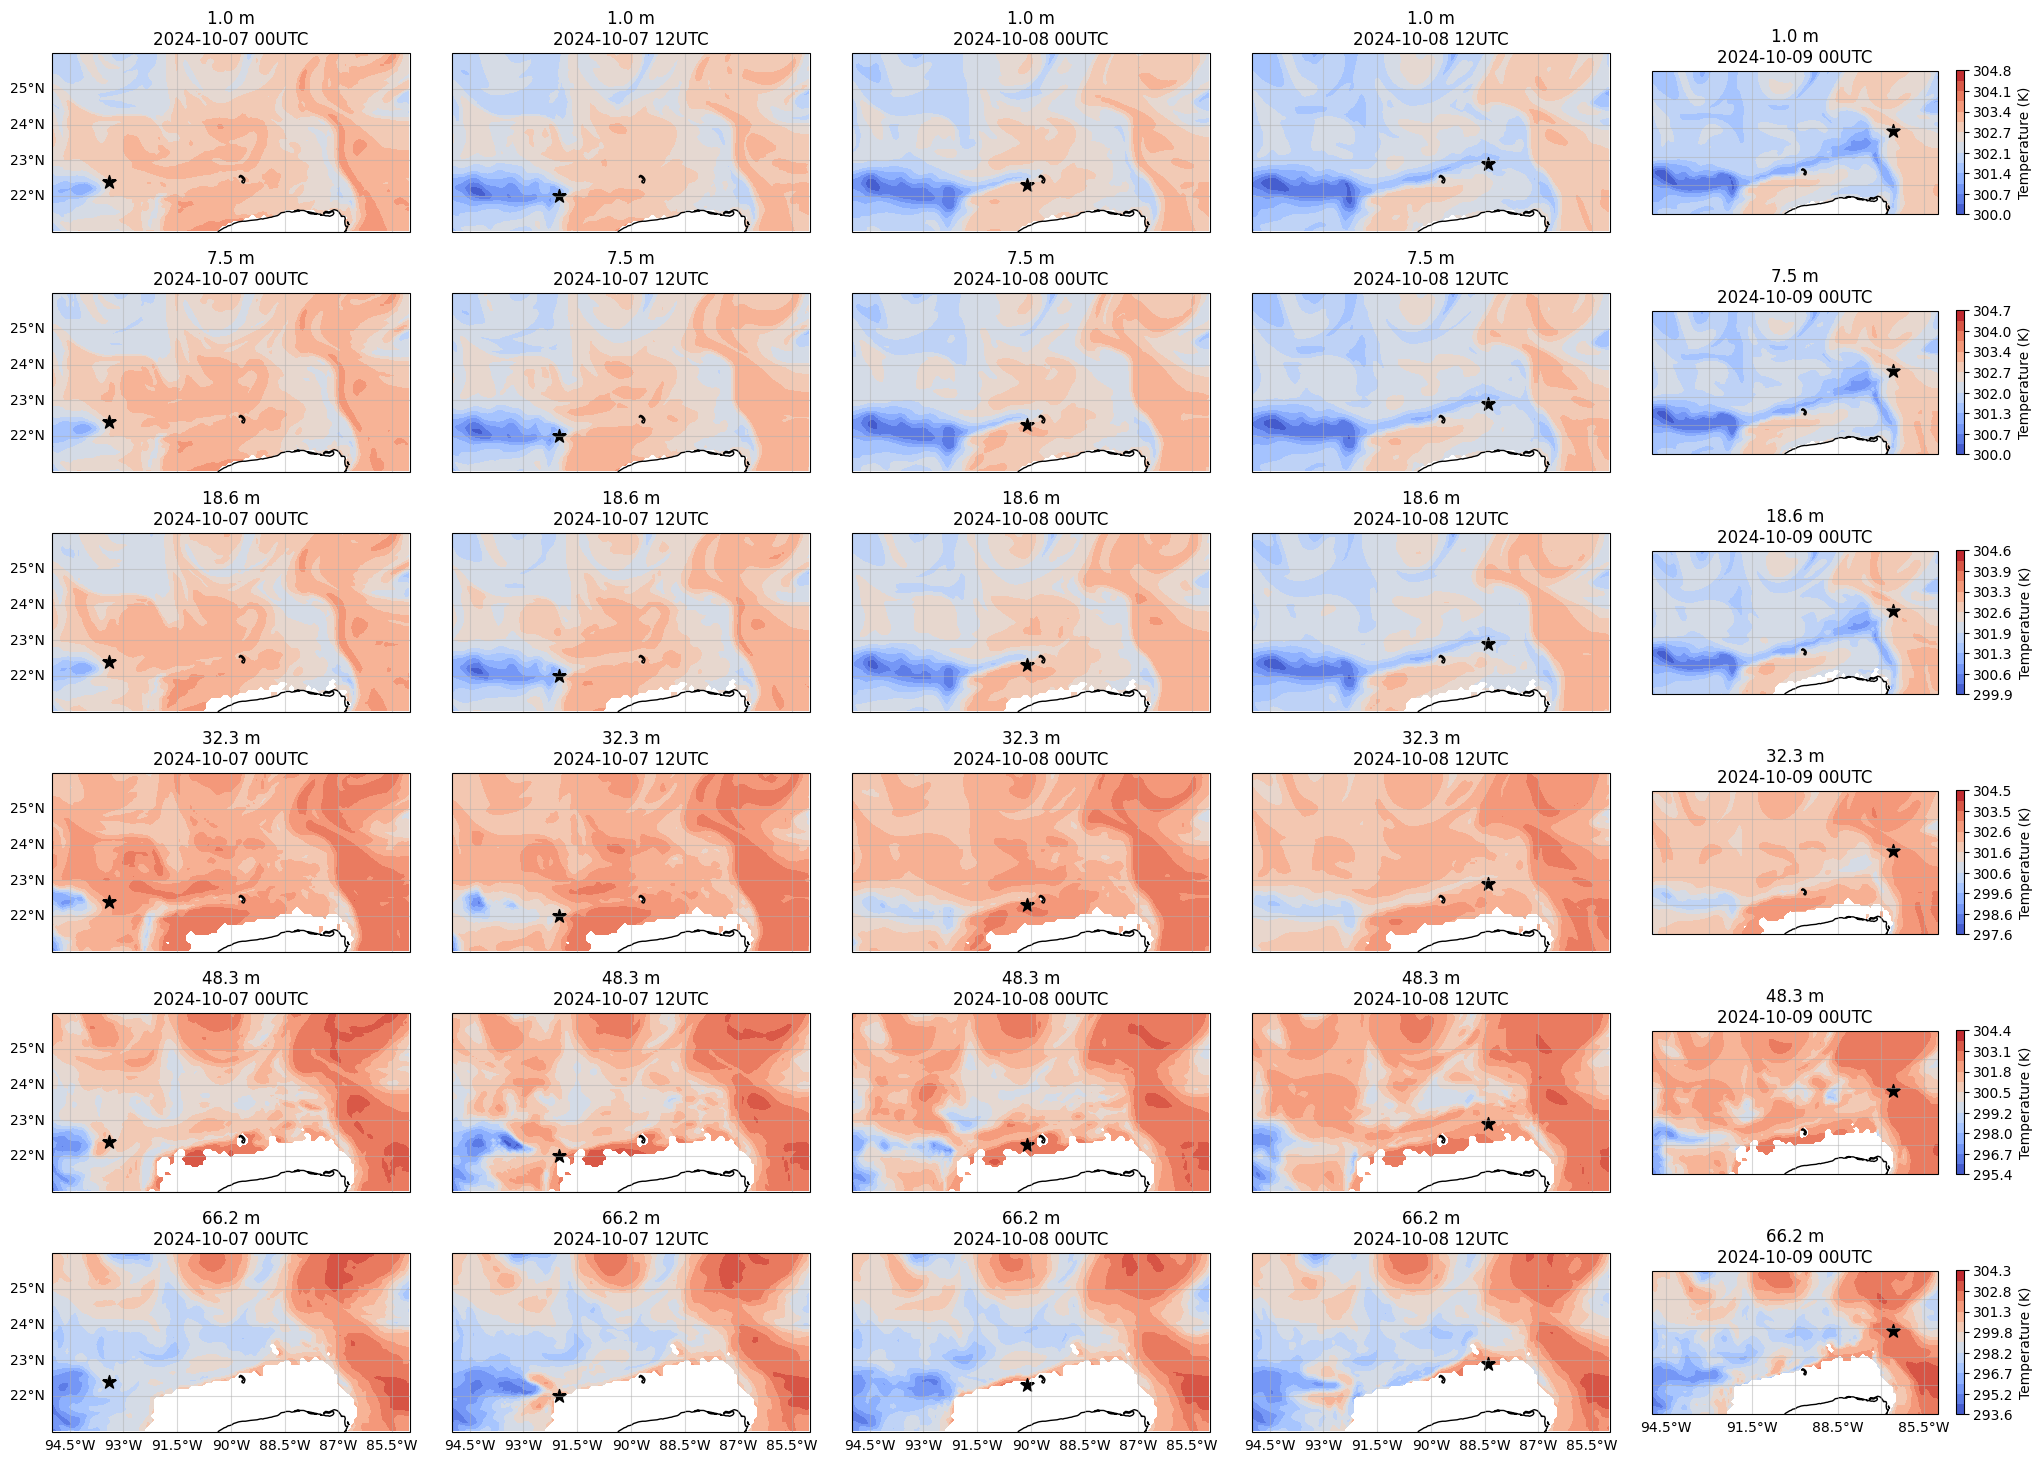

In [71]:
oceFig = plt.figure(figsize=(len(fcastTimes)*5,len(oceLayers)*6))
oceAxes = [[oceFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

contourLevs = {layer:["Empty"] for layer in atmLayers}

for valid, oceAxColumn in zip(fcastTimes, oceAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  oceFile = "mom6_" + initStr + initHour + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile
  oceData = xr.open_dataset(ocePath, decode_times=False)

  for oceLayer, oceAx in zip(oceLayers, oceAxColumn):

    oceSlice = oceData.isel(z_l=oceLayer).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax), time=oceData.time.data[0])

    temp = oceSlice.temp.data + 273.15
    if "Empty" in contourLevs[oceLayer]: contourLevs[oceLayer] = [round(l, 1) for l in np.linspace(min(temp[np.isnan(temp)==False])-1, max(temp[np.isnan(temp)==False])+1, 15)]

    tempContour = oceAx.contourf(oceSlice.xh.data, oceSlice.yh.data, temp, cmap="coolwarm", transform=ccrs.PlateCarree(),
                                extent=[lonMin, lonMax, latMin, latMax], levels=contourLevs[oceLayer])
    if valid == fcastTimes[-1]: oceFig.colorbar(tempContour, shrink=0.8, label="Temperature (K)")

    oceAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=100, transform=ccrs.PlateCarree())

    gridLabels = []
    if oceLayer == oceLayers[-1]: gridLabels.append("bottom")
    if valid == fcastTimes[0]: gridLabels.append("left")
    oceAx.gridlines(draw_labels=gridLabels, alpha=0.5)

    oceAx.add_feature(cft.COASTLINE)
    oceAx.add_feature(cft.BORDERS)
    oceAx.set_title(f"{round(oceData.z_l.data[oceLayer],1)} m\n{valid.strftime('%Y-%m-%d %HUTC')}")

    oceAx.set_extent([lonMin, lonMax, latMin, latMax])

#oceFig.suptitle(f"Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

Atmosphere Temperature Difference by Level

/tmp/ipython-input-72-3840732957.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-72-3840732957.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue d

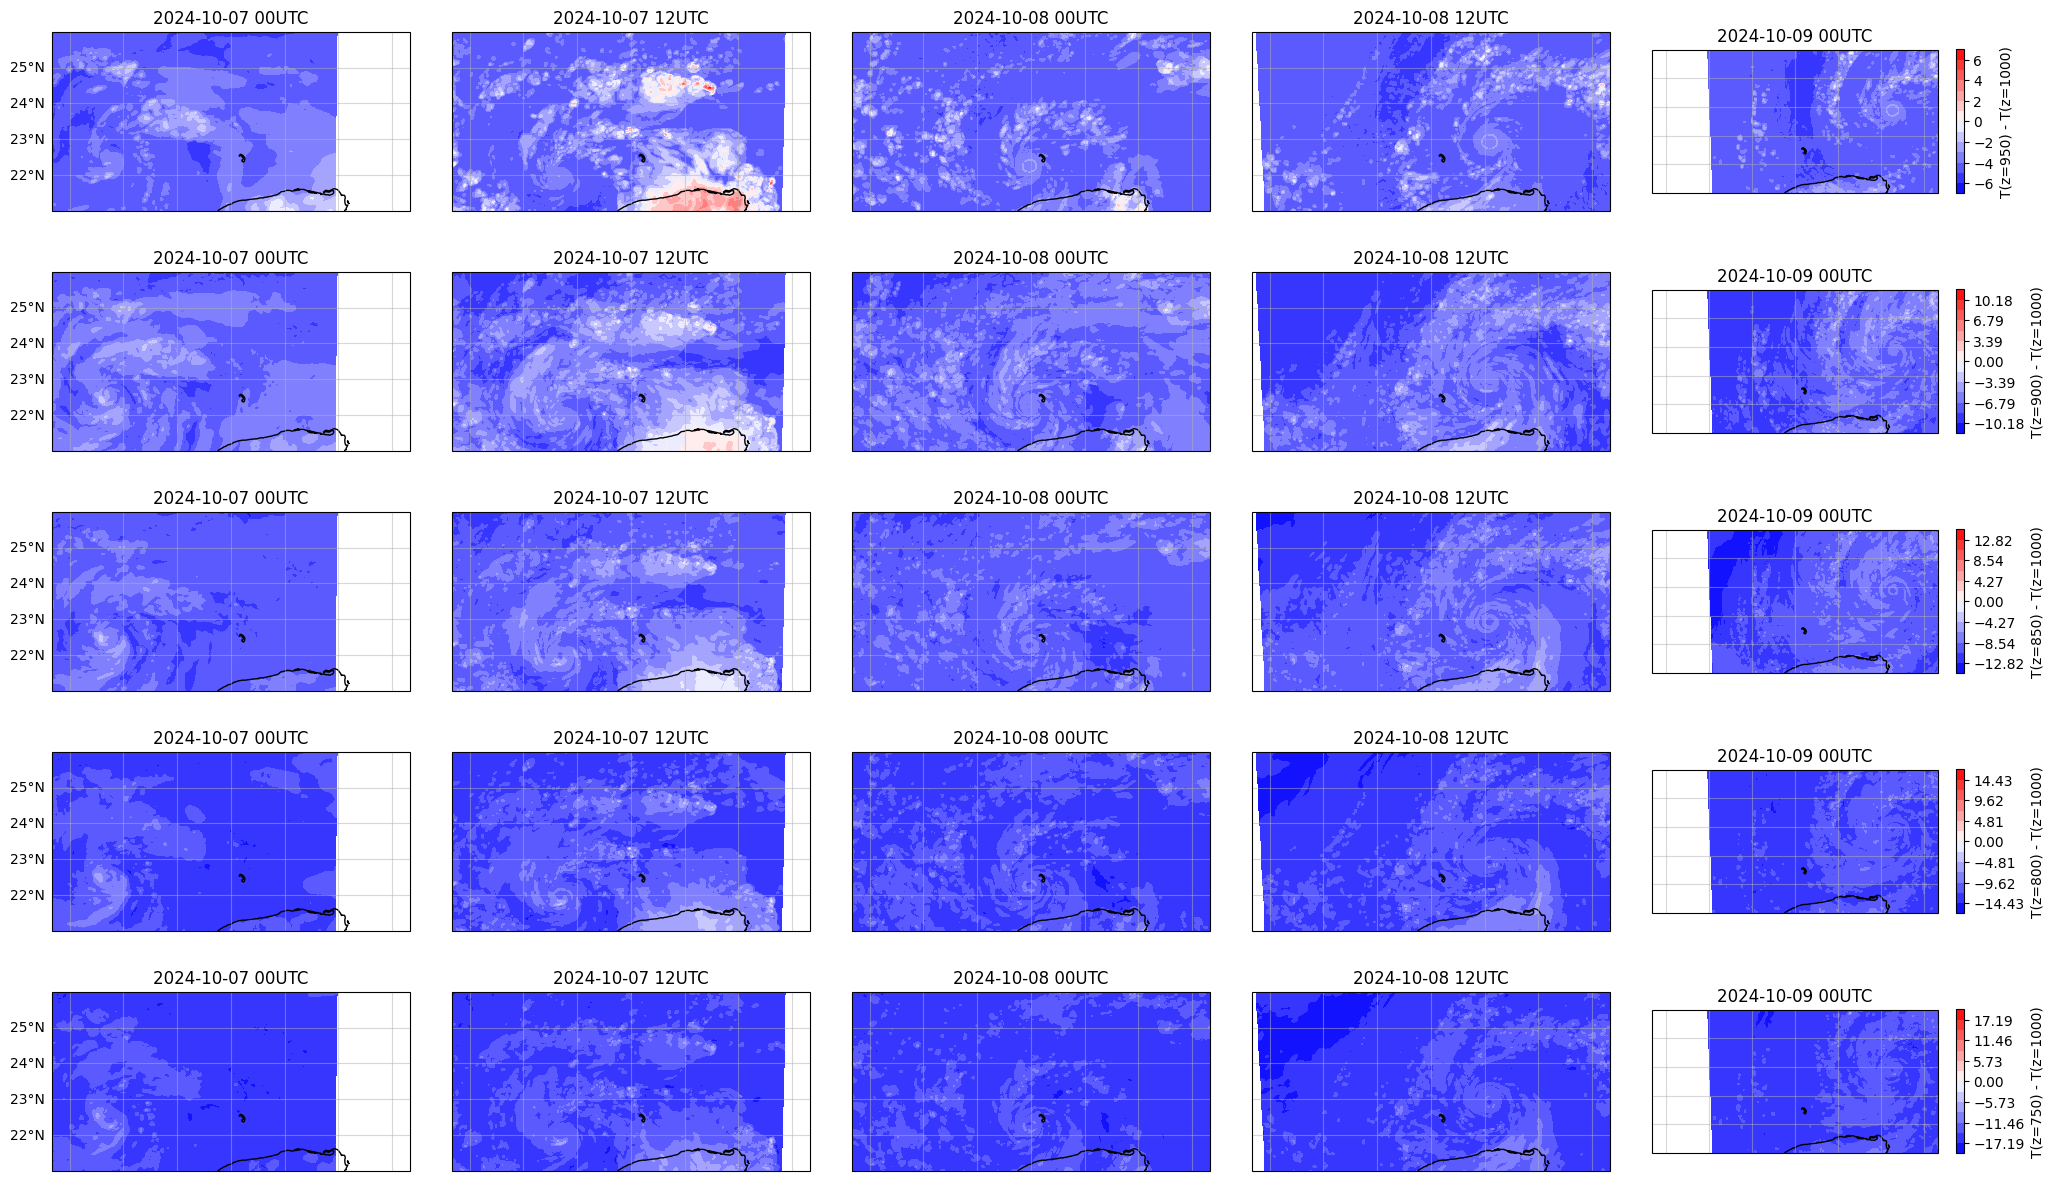

In [72]:
atmFig = plt.figure(figsize=(len(fcastTimes)*5,len(atmLayers)*6))
atmAxes = [[atmFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners[:-1]] for xcorner in xcorners]

contourLevs = {layer:["Empty"] for layer in atmLayers}
for valid, atmAxColumn in zip(fcastTimes, atmAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + initHour + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  lowerLayers = {"top":[0]*len(atmLayers[:-1]), "incremental":atmLayers[1:]}[diffType]
  for upperLayer, lowerLayer, atmAx in zip(atmLayers[1:], lowerLayers, atmAxColumn):

    upperSlice = atmData.isel(isobaricInhPa=upperLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))
    lowerSlice = atmData.isel(isobaricInhPa=lowerLayer).sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))

    if potentialTemp: tdiff = (upperSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286) - (lowerSlice.t.data * (1000/atmSlice.isobaricInhPa.data) ** 0.286)
    else: tdiff = upperSlice.t.data - lowerSlice.t.data

    if "Empty" in contourLevs[upperLayer]: contourLevs[upperLayer] = np.round(np.linspace(-1*(np.max(abs(tdiff[np.isnan(tdiff)==False]))+1), np.max(abs(tdiff[np.isnan(tdiff)==False]))+1, 15), 2)

    tempContour = atmAx.contourf(upperSlice.longitude.data, upperSlice.latitude.data, tdiff, cmap="bwr", transform=ccrs.PlateCarree(),
                                extent = [lonMin, lonMax, latMin, latMax], levels=contourLevs[upperLayer])
    if valid == fcastTimes[-1]: atmFig.colorbar(tempContour, shrink=0.8, label=f"T(z={int(atmData.isobaricInhPa.data[upperLayer])}) - T(z={int(atmData.isobaricInhPa.data[lowerLayer])})")

    #atmAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=75, transform=ccrs.PlateCarree())
    gridLabels = []
    if lowerLayer == oceLayers[-1]: gridLabels.append("bottom")
    if valid == fcastTimes[0]: gridLabels.append("left")
    atmAx.gridlines(draw_labels=gridLabels, alpha=0.5)

    atmAx.add_feature(cft.COASTLINE)
    atmAx.add_feature(cft.BORDERS)
    atmAx.set_title(valid.strftime("%Y-%m-%d %HUTC"))

    atmAx.set_extent([lonMin, lonMax, latMin, latMax])

#atmFig.suptitle(f"Atmosphere Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

Ocean Temperature Difference by Level

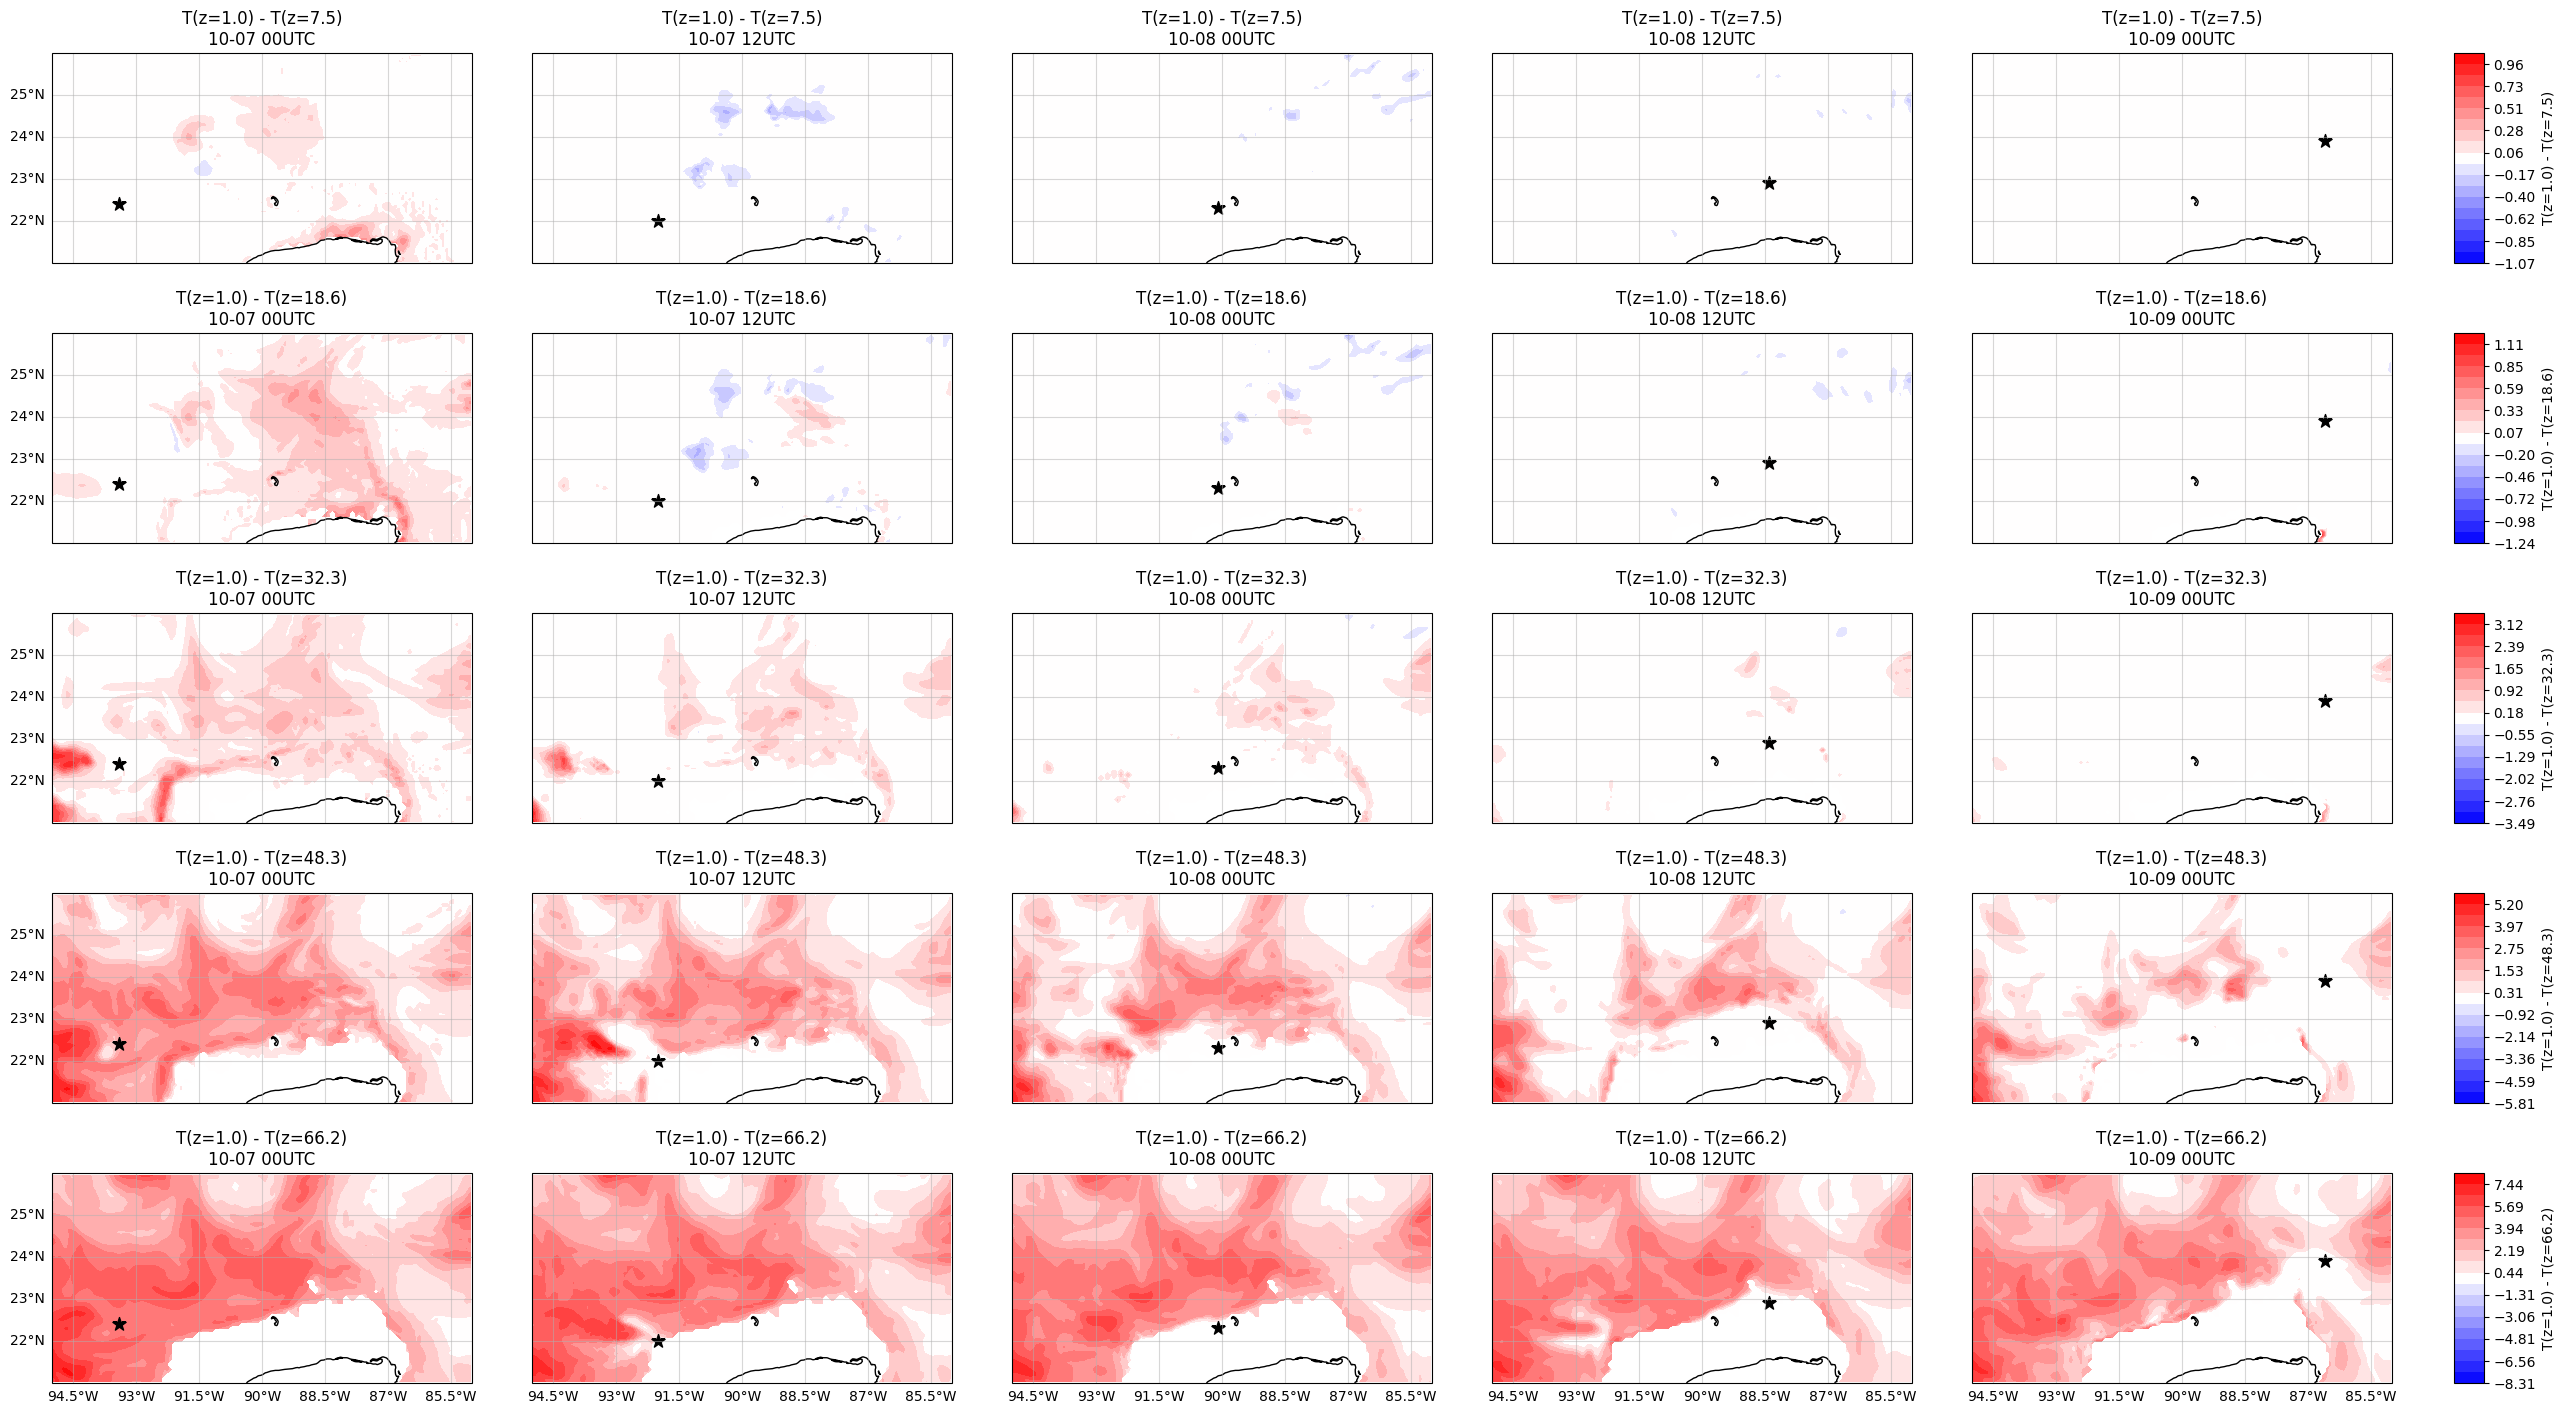

In [73]:
oceFig = plt.figure(figsize=(len(fcastTimes)*6,len(oceLayers)*7))
oceAxes = [[oceFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners[:-1]] for xcorner in xcorners]

contourLevs = {layer:["Empty"] for layer in oceLayers}

for valid, oceAxColumn in zip(fcastTimes, oceAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  oceFile = "mom6_" + initStr + initHour + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile
  oceData = xr.open_dataset(ocePath, decode_times=False)

  upperLayers = {"top":[0]*len(oceLayers[:-1]), "incremental":oceLayers[:-1]}[diffType]
  for upperLayer, lowerLayer, oceAx in zip(upperLayers, oceLayers[1:], oceAxColumn):

    upperSlice = oceData.isel(z_l=upperLayer, time=0).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax))
    lowerSlice = oceData.isel(z_l=lowerLayer, time=0).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax))

    tdiff = upperSlice.temp.data - lowerSlice.temp.data

    maxContour = np.max(abs(tdiff[np.isnan(tdiff)==False]))+0.5
    if "Empty" in contourLevs[lowerLayer]: contourLevs[lowerLayer] = np.round(np.linspace(-maxContour, maxContour, 20), 2)

    #oceSlice = oceData.isel(z_l=oceLayer).sel(xh=slice(lonMin, lonMax), yh=slice(latMin, latMax), time=oceData.time.data[0]

    tempContour = oceAx.contourf(lowerSlice.xh.data, lowerSlice.yh.data, tdiff, cmap="bwr", transform=ccrs.PlateCarree(),
                                extent=[lonMin, lonMax, latMin, latMax], levels=contourLevs[lowerLayer])
    if valid == fcastTimes[-1]:
      cax = oceFig.add_axes([oceAx.get_position().get_points()[1, 0]+0.02, oceAx.get_position().get_points()[0, 1], 0.01, 0.05])
      oceFig.colorbar(tempContour, cax=cax, shrink=0.4, label=f"T(z={round(oceData.z_l.data[upperLayer],1)}) - T(z={round(oceData.z_l.data[lowerLayer],1)})")
    if valid == fcastTimes[0]: oceAx.set_ylabel(f"{round(oceData.z_l.data[upperLayer],1)} - {round(oceData.z_l.data[lowerLayer],1)} m")

    oceAx.scatter(tcLocs[valid][1], tcLocs[valid][0], marker="*", color="black", s=100, transform=ccrs.PlateCarree())

    gridLabels = []
    if lowerLayer == oceLayers[-1]: gridLabels.append("bottom")
    if valid == fcastTimes[0]: gridLabels.append("left")
    oceAx.gridlines(draw_labels=gridLabels, alpha=0.5)

    oceAx.add_feature(cft.COASTLINE)
    oceAx.add_feature(cft.BORDERS)
    oceAx.set_title(f"T(z={round(oceData.z_l.data[upperLayer],1)}) - T(z={round(oceData.z_l.data[lowerLayer],1)})" + "\n" + valid.strftime('%m-%d %HUTC'))

    oceAx.set_extent([lonMin, lonMax, latMin, latMax])

#oceFig.suptitle(f"Initialized {initTime.strftime('%Y-%m-%d %HUTC')}")

Plot of Vertical Model Resolution

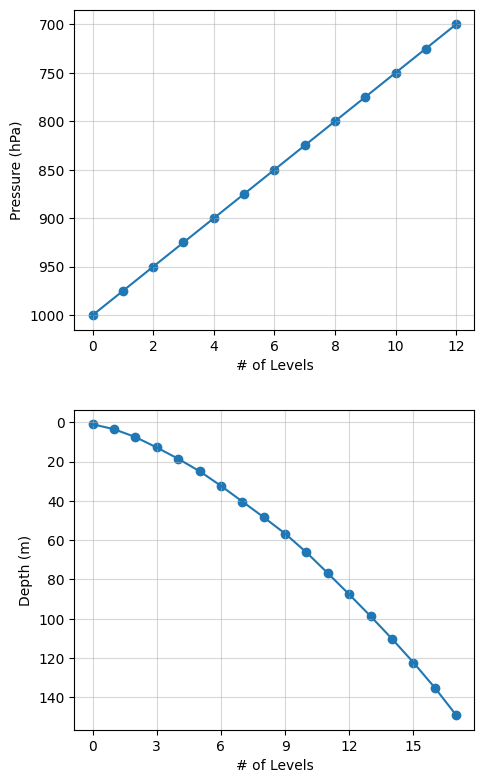

In [74]:
resFig = plt.figure(figsize=(5, 8))
atmAx = resFig.add_axes([0.1, 0.55, 0.8, 0.4])
oceAx = resFig.add_axes([0.1, 0.05, 0.8, 0.4])

atmAx.plot(np.arange(0, len(atmData.isobaricInhPa.data)), atmData.isobaricInhPa.data, label="Atmosphere")
atmAx.scatter(np.arange(0, len(atmData.isobaricInhPa.data)), atmData.isobaricInhPa.data)

oceZ = oceData.z_l.data[oceData.z_l.data<=150]
oceAx.plot(np.arange(0, len(oceZ)), oceZ, label="Ocean")
oceAx.scatter(np.arange(0, len(oceZ)), oceZ)
oceAx.set_xticks(np.arange(0, len(oceZ), 3))

atmAx.grid(alpha=0.5)
atmAx.set_xlabel("# of Levels")
atmAx.set_ylabel("Pressure (hPa)")
atmAx.invert_yaxis()

oceAx.grid(alpha=0.5)
oceAx.set_xlabel("# of Levels")
oceAx.set_ylabel("Depth (m)")
oceAx.invert_yaxis()

#Amtospheric Fluxes and Wind Stress

In [75]:
vars = ["Latent Heat Flux", "Total Heat Flux", "Wind Speed", "SST"]
varUnits = {"Momentum Flux":"N m$^{-2}$", "Latent Heat Flux":"W m$^{-2}$", "Total Heat Flux":"W m$^{-2}$", "SST":"K", "Wind Speed":"m s$^{-1}$"}
cmaps = {"Momentum Flux":"cividis", "Latent Heat Flux":"summer_r", "Total Heat Flux":"plasma_r", "SST":"coolwarm", "Wind Speed":"viridis"}

buffer = 0.1 / len(vars)
xWidth = 0.8 / len(fcastTimes)
yWidth = 0.8 / len(vars)
xcorners = np.arange(0.1,0.9,xWidth)
ycorners = np.arange(0.1,0.8,yWidth)

mapRadius = 0.5 #in degrees

In [76]:
allData = {valid:{} for valid in allTimes}
allDims = {"lat":{}, "lon":{}}

for valid in allTimes:

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + initHour + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath, decode_timedelta=False)

  lonMin, lonMax, latMin, latMax = tcLocs[valid][1]-mapRadius, tcLocs[valid][1]+mapRadius, tcLocs[valid][0]-mapRadius, tcLocs[valid][0]+mapRadius
  atmSlice = atmData.sel(longitude=slice(lonMin+360, lonMax+360), latitude=slice(latMin, latMax))
  allData[valid]["Total Heat Flux"] = (atmSlice.slhtf.data + atmSlice.ishf.data + atmSlice.sulwrf.data) * -1
  allData[valid]["Latent Heat Flux"] = atmSlice.slhtf.data * -1
  allData[valid]["Momentum Flux"] = (atmSlice.utaua.data**2 + atmSlice.vtaua.data**2)**0.5
  allData[valid]["SST"] = atmSlice.sst.data
  allData[valid]["Wind Speed"] = (atmSlice.u.sel(isobaricInhPa=1000.0).data**2 + atmSlice.v.sel(isobaricInhPa=1000.0).data**2)**0.5

  allDims["lat"][valid] = atmSlice.latitude.data
  allDims["lon"][valid] = atmSlice.longitude.data

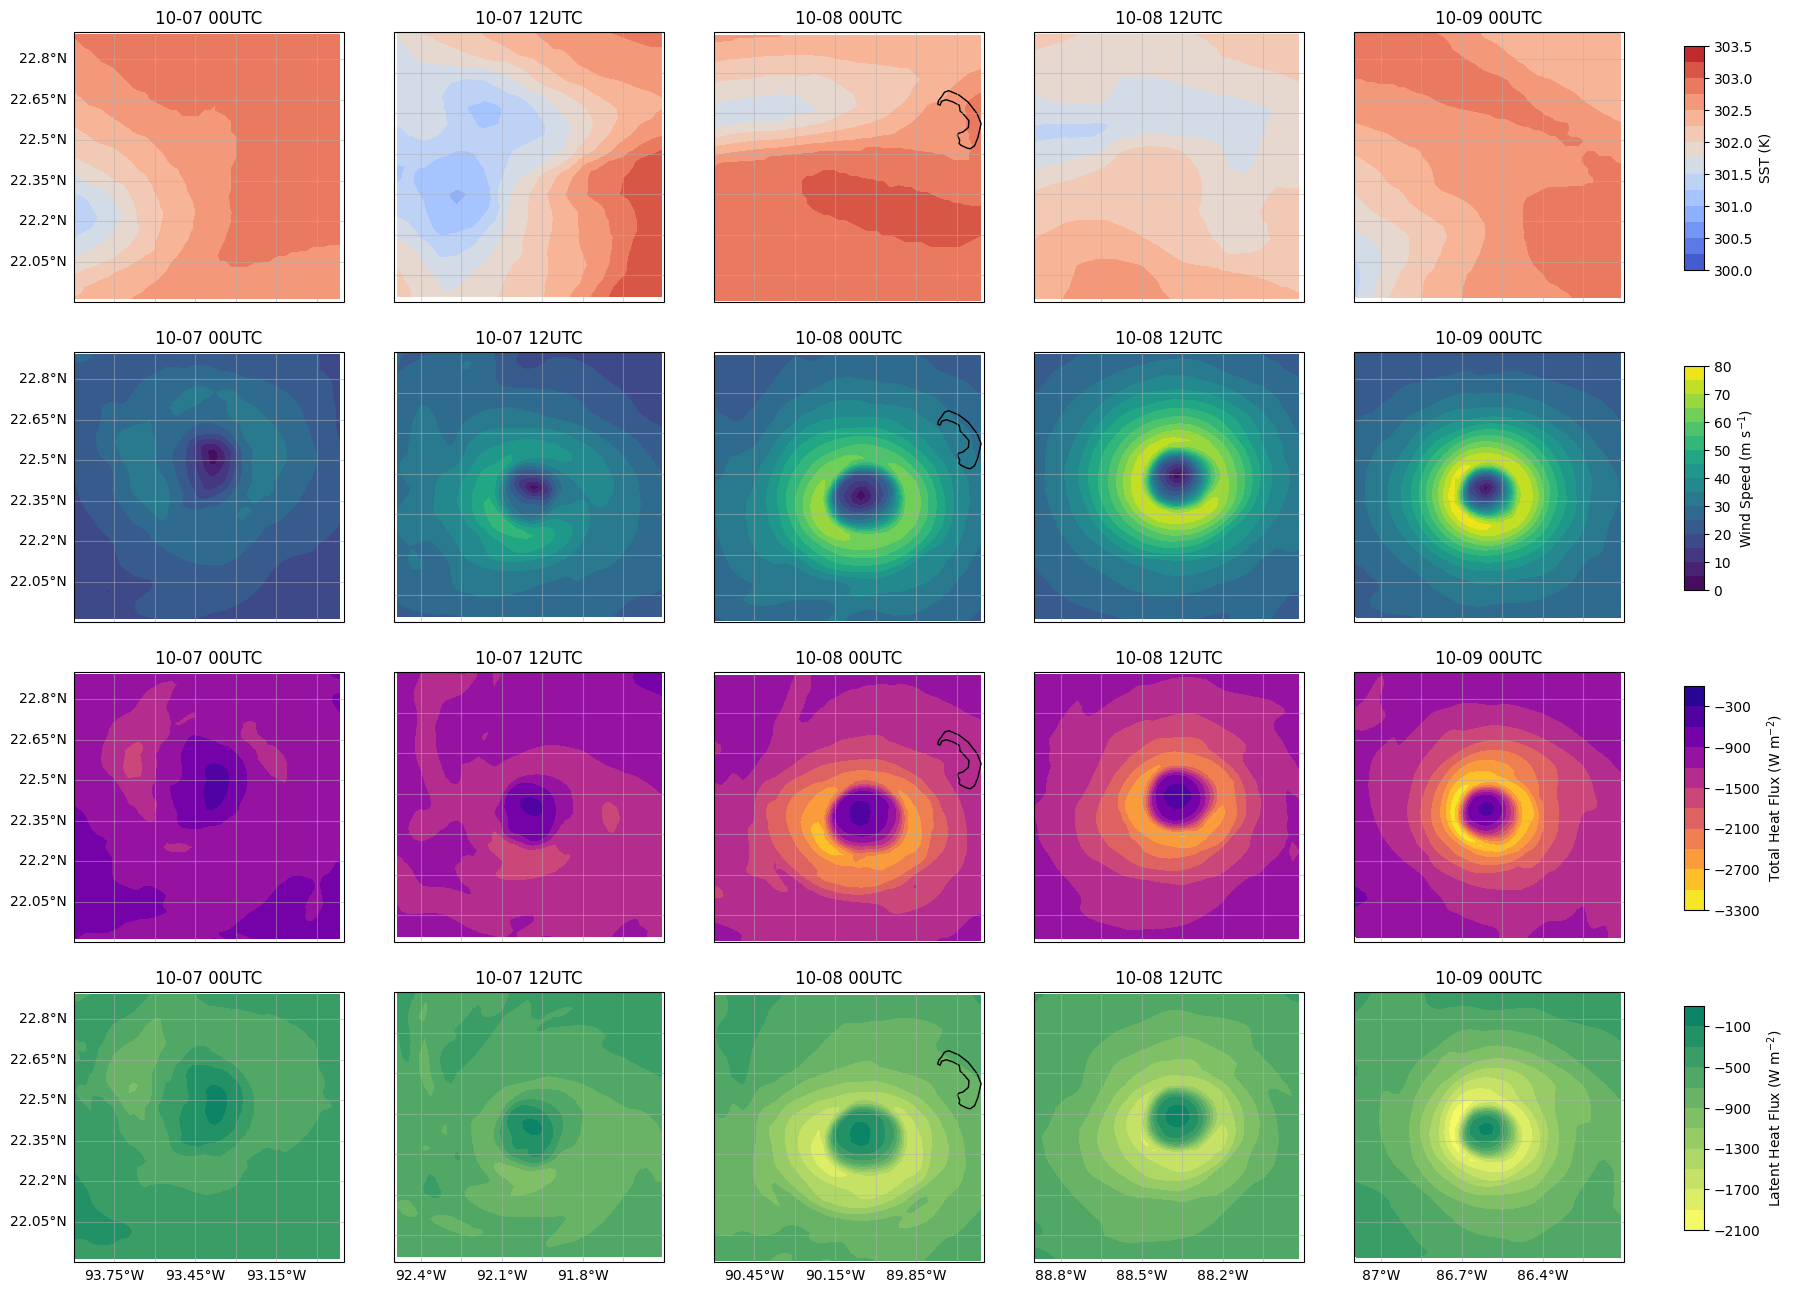

In [77]:
atmFig = plt.figure(figsize=(len(fcastTimes)*4,len(vars)*4))
atmAxes = [[atmFig.add_axes([xcorner, ycorner, xWidth-buffer, yWidth-buffer], projection=ccrs.PlateCarree()) for ycorner in ycorners] for xcorner in xcorners]

contourLevs = {"Wind Speed":np.linspace(0,80,17), "Total Heat Flux": np.linspace(-3300, 0, 12), "Latent Heat Flux":np.linspace(-2100, 100, 12),
               "Momentum Flux": np.linspace(-12, 0, 13), "SST": np.linspace(300.0, 303.5, 15)}

for valid, atmAxColumn in zip(fcastTimes, atmAxes):
  for var, atmAx in zip(vars, atmAxColumn):

    data = allData[valid][var]
    contour = atmAx.contourf(allDims["lon"][valid], allDims["lat"][valid], data, cmap=cmaps[var], transform=ccrs.PlateCarree(), levels=contourLevs[var])

    labelSides = []
    if var == vars[-0]: labelSides.append("bottom")
    if valid == fcastTimes[0]: labelSides.append("left")
    atmAx.gridlines(draw_labels=labelSides, alpha=0.5)

    atmAx.set_title(valid.strftime('%m-%d %HUTC'))
    atmAx.add_feature(cft.COASTLINE)
    atmAx.add_feature(cft.BORDERS)

    cbarTicks = [contourLevs[var][i] for i in range(len(contourLevs[var])) if i%2 == 0]
    if valid == fcastTimes[-1]:
      cax = atmFig.add_axes([atmAx.get_position().get_points()[1, 0]+0.03, atmAx.get_position().get_points()[0, 1]+0.02, 0.01, 0.14])
      atmFig.colorbar(contour, cax=cax, ticks=cbarTicks, label=f"{var} ({varUnits[var]})")

    lonMin, lonMax, latMin, latMax = tcLocs[valid][1]-mapRadius, tcLocs[valid][1]+mapRadius, tcLocs[valid][0]-mapRadius, tcLocs[valid][0]+mapRadius
    atmAx.set_extent([lonMin, lonMax, latMin, latMax])

In [78]:
# Get the shape of the data arrays (assuming all variables have the same spatial dimensions)
lat_dim = len(allDims["lat"][fcastTimes[0]])
lon_dim = len(allDims["lon"][fcastTimes[0]])
#lon_dim = allData[fcastTimes[0]]["Total Heat Flux"].shape

# Initialize a dictionary to store correlation coefficients
correlation_data = {}
correlation_pairs = [
    ("Total Heat Flux", "SST"),
    ("Latent Heat Flux", "SST"),
    ("Total Heat Flux", "Wind Speed"),
    ("Latent Heat Flux", "Wind Speed")]

for fluxVar, envVar in correlation_pairs:
    correlation_data[fluxVar.lower()+envVar.lower()] = np.full((lat_dim, lon_dim), np.nan)

# Iterate through each spatial point
for i in range(lat_dim):
    for j in range(lon_dim):
        # Extract time series data for the current spatial point
        time_series_data = {}
        for var in set([pair[0] for pair in correlation_pairs] + [pair[1] for pair in correlation_pairs]):
            time_series_data[var] = np.array([allData[valid][var][i, j] for valid in allTimes])

        # Remove NaN values from the time series
        valid_indices = ~np.isnan(time_series_data[correlation_pairs[0][0]]) # Use one of the variables to check for valid indices
        for var in time_series_data:
            valid_indices = valid_indices & ~np.isnan(time_series_data[var])

        # Calculate correlation only if there are enough valid data points (at least 2 for correlation)
        for fluxVar, envVar in correlation_pairs:
            ts1_valid = time_series_data[fluxVar][valid_indices]
            ts2_valid = time_series_data[envVar][valid_indices]
            if len(ts1_valid) >= 2 and len(ts2_valid) >= 2:
                correlation_data[fluxVar.lower()+envVar.lower()][i, j] = np.corrcoef(ts1_valid, ts2_valid)[0, 1]

In [79]:
envVar = "sst"

for valid, axColumn in zip(fcastTimes, atmAxes):
  for var, ax in zip(vars, axColumn):
    if var == "Total Heat Flux":
      c = ax.contour(allDims["lon"][valid], allDims["lat"][valid], correlation_data[var.lower()+envVar.lower()], transform=ccrs.PlateCarree(), levels=np.arange(-0.9, 1, 0.3), cmap="bwr")
      ax.clabel(c)
    if var == "Latent Heat Flux":
      c = ax.contour(allDims["lon"][valid], allDims["lat"][valid], correlation_data[var.lower()+envVar.lower()], transform=ccrs.PlateCarree(), levels=np.arange(-0.9, 1, 0.3), cmap="bwr")
      ax.clabel(c)

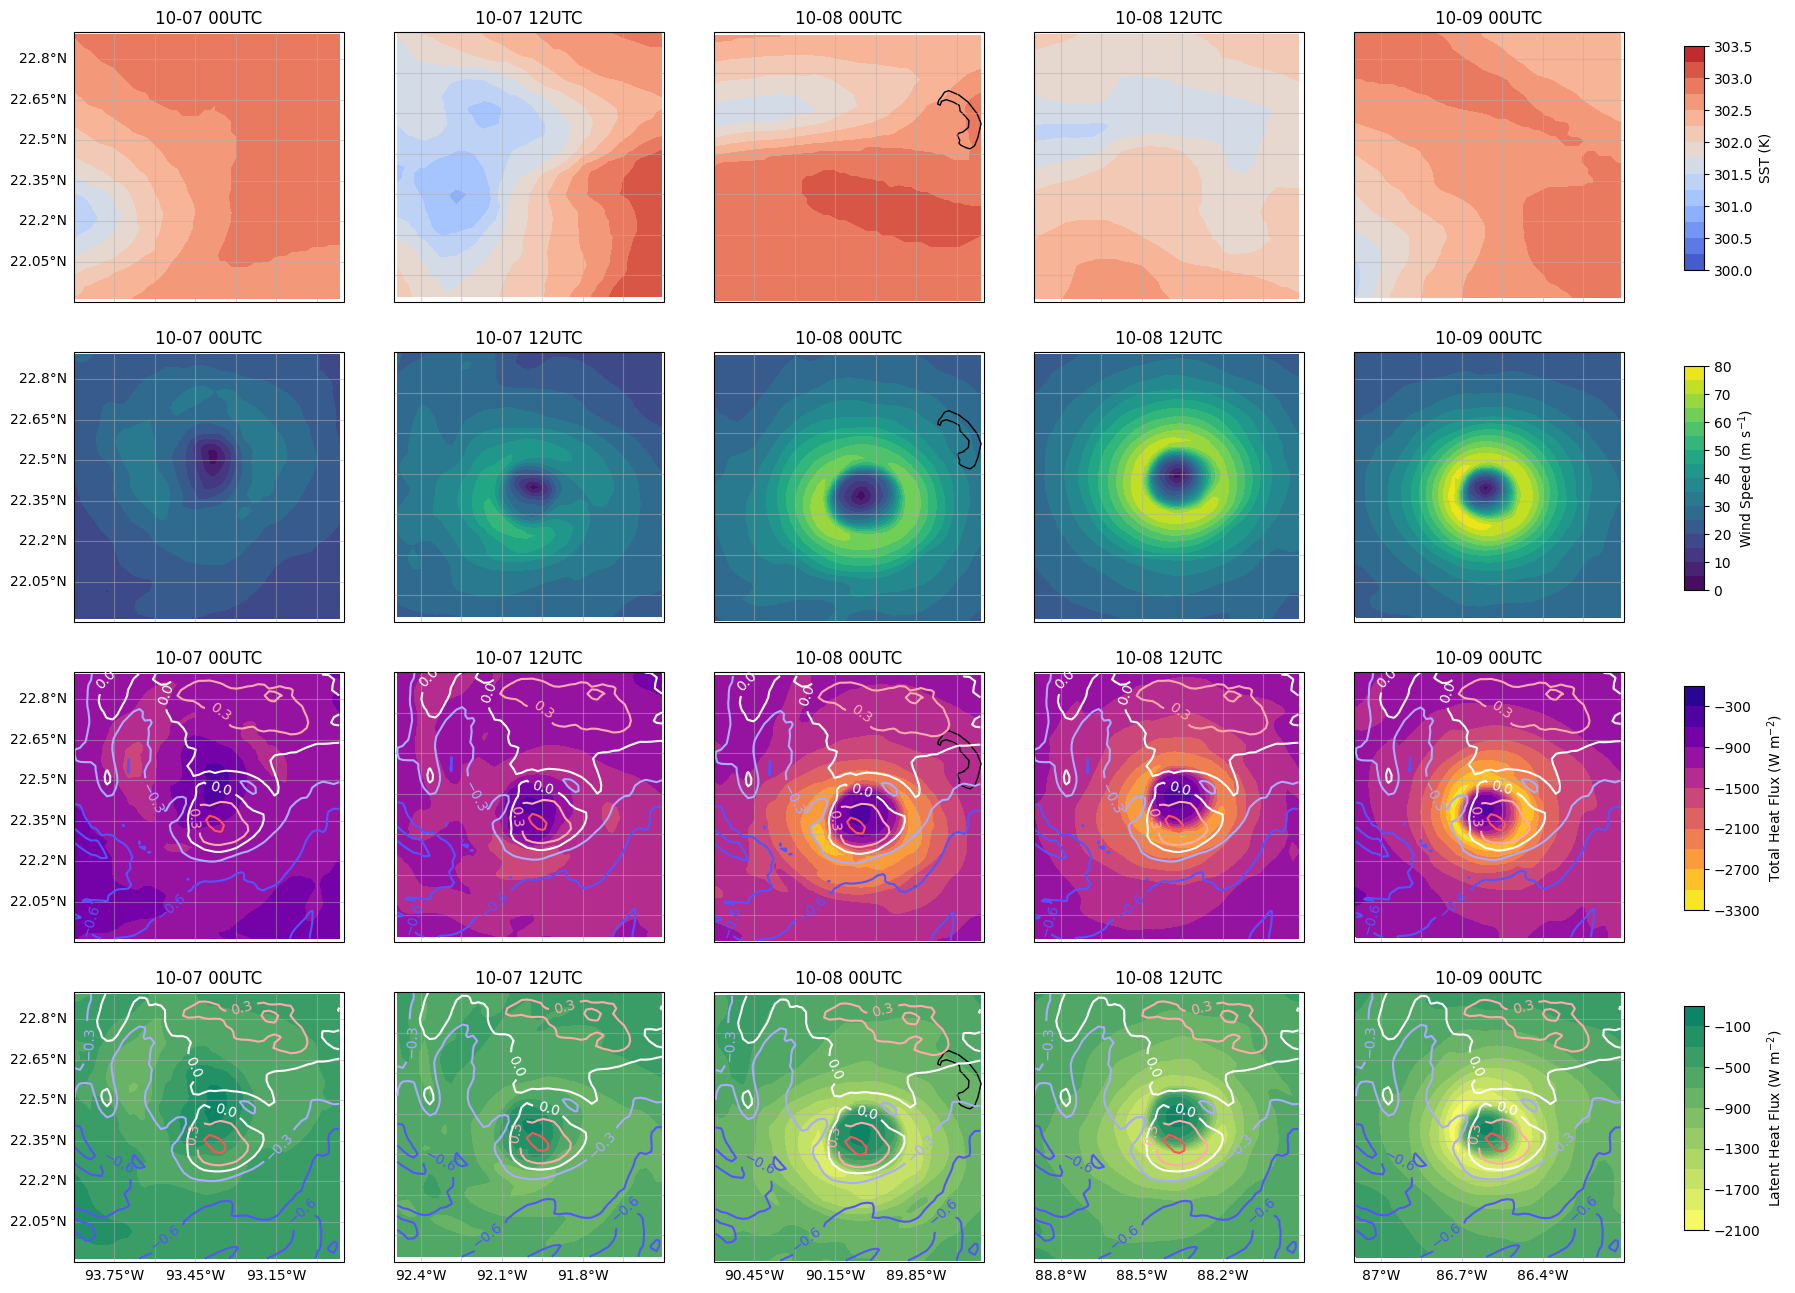

In [80]:
atmFig